In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Instalar librerías

!pip install rdkit
!pip install Biopython
!pip install pandarallel
!pip install py3Dmol

In [ ]:
#@title Abrir el dataframe

import os
import pandas as pd

input_folder = "/content/drive/MyDrive/TFM/T2/Analisis_dataframe_final"
input_file = os.path.join(input_folder, "df_filtro_binana_final.csv")
df_harm = pd.read_csv(input_file, sep = ',')
print(df_harm.shape[0],df_harm.columns)

70378 Index(['level_0', 'index', 'PDB_entry_id', 'Classification', 'Organism',
       'Uniprot_id', 'Ligand_id', 'Ligand_InChi', 'Experimental_method',
       'Resolution', 'Adding_Classification', 'Affinity', 'Coordenadas',
       'Ligand_smiles', 'Mol_Weight', 'n_atoms', 'Nombre', 'Classification_y',
       'Count_general', 'Count_diff'],
      dtype='object')


In [ ]:
#@title comprobar output USR grupos ligandos de los sitios de unión

list_output_USR_ligandos = os.listdir("/content/drive/MyDrive/TFM/T2/Ultrafast_Shape_Recognition/USR_sitios_de_union/Output_USR_sitios")

In [ ]:
print(len(list_output_USR_ligandos))

2880


In [ ]:
list_output_USR_ligandos

In [ ]:
list_output_USR_ligandos_1 = [i.replace("USR_","").replace("_sitio.csv","") for i in list_output_USR_ligandos]

In [ ]:
list_output_USR_ligandos_1

In [ ]:
ligandos_unicos_dataframe = list(set(df_harm['Ligand_id'].tolist()))
print(len(ligandos_unicos_dataframe))

2880


In [ ]:
#@title identifiar faltas si hay

falta_ligandos = []

for ligando in ligandos_unicos_dataframe:
  if ligando not in list_output_USR_ligandos_1:
    falta_ligandos.append(ligando)

print(len(falta_ligandos))

0


In [ ]:
# Cargar el CSV
data = pd.read_csv('/content/drive/MyDrive/TFM/T2/Ultrafast_Shape_Recognition/USR_sitios_de_union/Output_USR_sitios/USR_ZUG_sitio.csv', sep =",")

In [ ]:
data

,conformation,USR_1,USR_2,USR_3,USR_4,USR_5,USR_6,USR_7,USR_8,USR_9,USR_10,USR_11,USR_12
0,7H3L_ZUG_A_201_sitio.pdb,4.28797,1.57244,1.48332,4.45934,3.31720,1.45722,7.54499,9.09176,1.56279,7.38266,10.01929,1.52570
1,7HGJ_ZUG_B_103_sitio.pdb,6.26156,2.01268,1.49474,6.80056,6.16349,1.54729,10.54089,15.16278,1.46860,9.39125,13.48251,1.51524
2,7HGJ_ZUG_C_102_sitio.pdb,5.87301,2.15711,1.57840,6.20872,5.08021,1.62878,10.13646,16.74374,1.45406,9.47732,16.66433,1.36668
3,7HZN_ZUG_A_208_sitio.pdb,4.30638,1.55257,1.48271,4.47687,3.29498,1.46601,7.53937,8.87342,1.57580,7.36011,10.06989,1.50869


In [ ]:
#@title Función matrix de similitud

import os
import pandas as pd
import numpy as np

input_folder = "/content/drive/MyDrive/TFM/T2/Ultrafast_Shape_Recognition/USR_sitios_de_union/Output_USR_sitios"
output_folder = "/content/drive/MyDrive/TFM/T2/Ultrafast_Shape_Recognition/USR_sitios_de_union/Similarity_Matrices"

# Crear carpeta de salida si no existe
os.makedirs(output_folder, exist_ok=True)

for archivo in os.listdir(input_folder):
    archivo_file = os.path.join(input_folder, archivo)
    data = pd.read_csv(archivo_file, sep=",")

    nombre_ligando = archivo.replace("USR_","").replace("_sitio.csv","")

    descriptor_cols = [col for col in data.columns if col.startswith('USR_')]

    # Función de similitud USR
    def usr_similarity(vec1, vec2):
        return 1 / (1 + (np.sum(np.abs(vec1 - vec2)) / len(vec1)))

    # Calcular la matriz de similitud para todas las conformaciones
    descriptors = data[descriptor_cols].values
    n = descriptors.shape[0]
    sim_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i, n):
            sim = usr_similarity(descriptors[i], descriptors[j])
            sim_matrix[i, j] = sim
            sim_matrix[j, i] = sim  # simétrica

    # Guardar la matriz como CSV
    sim_df = pd.DataFrame(sim_matrix, index=data['conformation'], columns=data['conformation'])

    output_file = os.path.join(output_folder, f"sim_matrix_{nombre_ligando}.csv")
    sim_df.to_csv(output_file)

    print(f"Guardada matriz de similitud: {output_file}")









In [ ]:
import os
import pandas as pd
import numpy as np

input_folder = "/content/drive/MyDrive/TFM/T2/Ultrafast_Shape_Recognition/USR_sitios_de_union/Similarity_Matrices"
resultados = []

for archivo in os.listdir(input_folder):
    if archivo.endswith(".csv"):
        archivo_file = os.path.join(input_folder, archivo)
        df = pd.read_csv(archivo_file, index_col=0)

        sim_matrix = df.values

        if sim_matrix.shape[0] > 1:
            off_diag = sim_matrix[~np.eye(sim_matrix.shape[0], dtype=bool)]
            min_sim = np.min(off_diag)
            mean_sim = np.mean(off_diag)
        else:
            min_sim = 1.0
            mean_sim = 1.0

        resultados.append({
            'ligando': archivo.replace("sim_matrix_", ""),
            'min_sim': min_sim,
            'mean_sim': mean_sim
        })

# Crear DataFrame resumen
resultados_df = pd.DataFrame(resultados)

# Guardar en CSV
output_file = "/content/drive/MyDrive/TFM/T2/Ultrafast_Shape_Recognition/USR_sitios_de_union/similitud_resumen_sitios.csv"
resultados_df.to_csv(output_file, index=False)

print(f"Resumen guardado en: {output_file}")


Resumen guardado en: /content/drive/MyDrive/TFM/T2/Ultrafast_Shape_Recognition/USR_sitios_de_union/similitud_resumen_sitios.csv


In [ ]:
df_resumen = pd.read_csv("/content/drive/MyDrive/TFM/T2/Ultrafast_Shape_Recognition/USR_sitios_de_union/similitud_resumen_sitios.csv",sep = ',')

In [ ]:
df_resumen['ligando'] = df_resumen['ligando'].str.replace('.csv', '', regex=False)

In [ ]:
df_resumen.head()

,ligando,min_sim,mean_sim
0,L46,0.256704,0.256704
1,SAC,0.240576,0.376354
2,DA2,0.469981,0.529869
3,28E,0.171179,0.443484
4,22L,0.202518,0.393649


In [ ]:
df_resumen.shape[0]

2880

In [ ]:
print(len(ligandos_unicos_dataframe))

2880


In [ ]:
df_resumen_1 = df_resumen[df_resumen['ligando'].isin(ligandos_unicos_dataframe)]
df_resumen_1.shape[0]

2880

In [ ]:
df_resumen_1.to_csv("/content/drive/MyDrive/TFM/T2/Ultrafast_Shape_Recognition/similitud_resumen_df.csv",sep = ',', index = False)

In [ ]:
import pandas as pd

df_resumen = pd.read_csv("/content/drive/MyDrive/TFM/T2/Ultrafast_Shape_Recognition/similitud_resumen_df.csv",sep = ',')

In [ ]:
df_resumen.shape[0]

2884

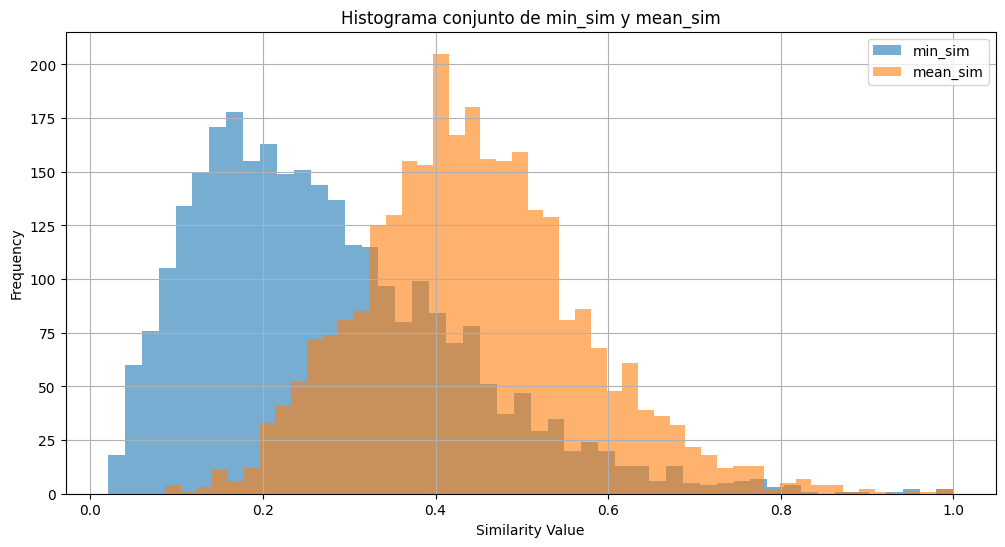

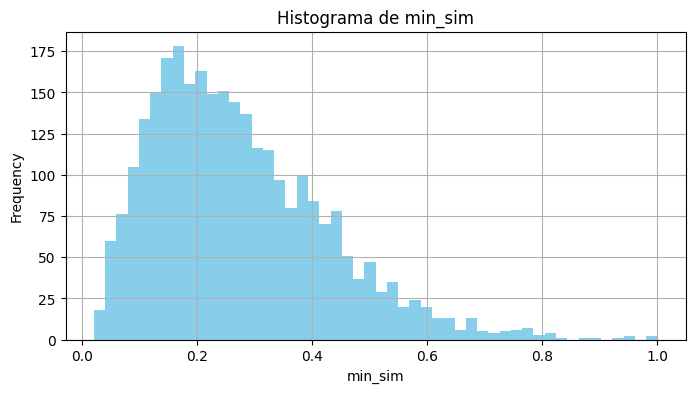

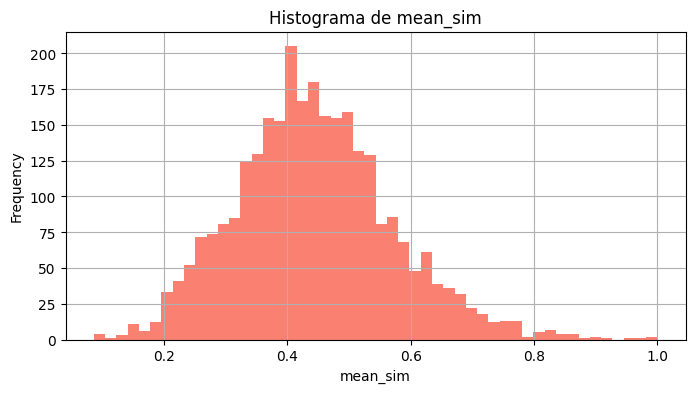

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Supongamos que ya tienes el DataFrame cargado como df

# Histograma conjunto
plt.figure(figsize=(12, 6))
plt.hist(df_resumen['min_sim'], bins=50, alpha=0.6, label='min_sim')
plt.hist(df_resumen['mean_sim'], bins=50, alpha=0.6, label='mean_sim')
plt.xlabel('Similarity Value')
plt.ylabel('Frequency')
plt.title('Histograma conjunto de min_sim y mean_sim')
plt.legend()
plt.grid(True)
plt.show()

# Histograma individual para min_sim
plt.figure(figsize=(8, 4))
plt.hist(df_resumen['min_sim'], bins=50, color='skyblue')
plt.xlabel('min_sim')
plt.ylabel('Frequency')
plt.title('Histograma de min_sim')
plt.grid(True)
plt.show()

# Histograma individual para mean_sim
plt.figure(figsize=(8, 4))
plt.hist(df_resumen['mean_sim'], bins=50, color='salmon')
plt.xlabel('mean_sim')
plt.ylabel('Frequency')
plt.title('Histograma de mean_sim')
plt.grid(True)
plt.show()
